<a href="https://colab.research.google.com/github/Gorodecki/Projects/blob/master/GAN_AIR_with_MASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PRO задание. Вариант 2
Сделайте генерацию изображений неба с самолётом, **добейтесь высокой степени реалистичности**

Для генерации можно использовать маску самолёта в качестве условия

# [статья](https://arxiv.org/abs/1611.07004)

In [2]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
import zipfile

# Поготовка данных

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
path_to_air_zip = '/content/drive/My Drive/Colab Notebooks/Neural Base/Данные/Air-20200719T210002Z-001.zip'
path_to_segment_zip = '/content/drive/My Drive/Colab Notebooks/Neural Base/Данные/Segment-20200719T210150Z-001.zip'

In [15]:
!mkdir images

In [38]:
zzz = zipfile.ZipFile(path_to_air_zip, 'r')
zzz.extractall(path='/content/images')
zzz = zipfile.ZipFile(path_to_segment_zip, 'r')
zzz.extractall(path='/content/images')

In [4]:
PATH = os.path.join(os.path.dirname('/content/'), 'images/')
PATH

'/content/images/'

In [5]:
BUFFER_SIZE = 800
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
PATH+'Segment/'+'airplane_1.jpg'

'/content/images/Segment/airplane_1.jpg'

In [11]:
# функция параллельной загрузки картинки с одинаковым именем в разных папках
def load(image_file, PATH=PATH):
  input_image = tf.io.read_file(PATH+'Segment/'+image_file)
  input_image = tf.image.decode_jpeg(input_image)

  real_image = tf.io.read_file(PATH+'Air/'+image_file)
  real_image = tf.image.decode_jpeg(real_image)


  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [13]:
# функция обрезки изображения (метод ближних)
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [14]:
# функция произвольной обрезки изображения (небольшое смещение)
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [15]:
# нормализуем для генераторов [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [16]:
# используем ускорение
@tf.function()
def random_jitter(input_image, real_image):
  # ресайз до 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # рандомная обрезка до 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # зеркальное отображение
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

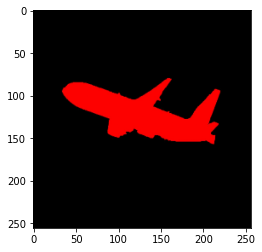

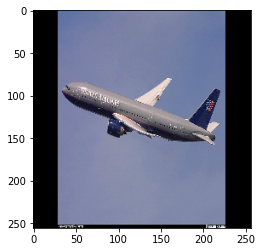

In [24]:
# вывод на экран для наглядности
inp, re = resize(*load('airplane_1.jpg'), IMG_WIDTH, IMG_HEIGHT)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

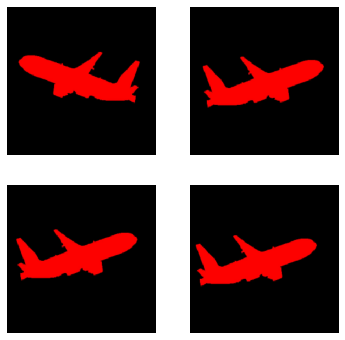

In [25]:
# смотрим что функция кроп не отрезала часть самолета
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [10]:
# функция подготовки изображения
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [18]:
# на обучающей выборке не надо обрезать, подаём как есть
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [7]:
# берём все названия файлов из папки самолёты
list_file = os.listdir('/content/images/Air')

In [53]:
# пайплайн по созданию датасета
train_dataset = tf.data.Dataset.from_tensor_slices(list_file[:800])
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE) # не особо разобрался что означает AUTOTUNE
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [54]:
# для тестовой берём 200 картинок
test_dataset = tf.data.Dataset.from_tensor_slices(list_file[800:])
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Генератор
  * Архитектура генератора взята из U-Net.
  * Блок энкодера -  (Conv -> Batchnorm -> Leaky ReLU)
  * Блок декодера -  (Transposed Conv -> Batchnorm -> Dropout(исп. на 3 блоках) -> ReLU)
  * Прокидываем соединение по всей сети (всё как в U-Net).


In [20]:
OUTPUT_CHANNELS = 3

In [27]:
# блок 1
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02) # инициализирует тензор из нормального распределения

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [28]:
# проверяем на картинке
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [29]:
# блок 2
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [30]:
# проверка на картнке
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [32]:
# генератор. bs - batch_size
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # сворачиваем
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # разворачиваем 
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [35]:
# инициализация
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


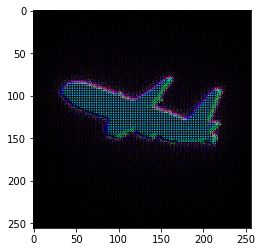

In [36]:
# проверка генератора на необученном генераторе
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

* **Ошибка генератора**
  *  Sigmoid cross entropy.
  * В [статье](https://arxiv.org/abs/1611.07004) также включена L1 ошибка, которая считается как, MAE (mean absolute error) между сгенерированным изображением и настоящим.
  * Это позволяет сгенерированному изображению стать структурно похожим на реальное изображение.
  * Формула для  total generator loss = gan_loss + LAMBDA * l1_loss, где LAMBDA = 100. Это значение было выбрано автором [статьи](https://arxiv.org/abs/1611.07004).

Процедура обучения генератора с картинками:

In [37]:
LAMBDA = 100

In [38]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Дискриминатор
  * Дискриминатор PatchGAN.
  * Блок дескриминатора (Conv -> BatchNorm -> Leaky ReLU)
  * Выход после последнего слоя будет (batch_size, 30, 30, 1)
  * Каждый 30x30 мини-блок классифицирует 70x70 блока входного изображения (такой принцип взят из PatchGAN).
  * Дискриминатор получает 2 входа.
    * Картинка вход и реальное изображение, который он должен определить как реальный.
    * Картинка вход и сгенерированное изображение (выход из генератора), который определить как фэйк.
    * Объединяем эти два слоя функцией (`tf.concat([inp, tar], axis=-1)`)

In [39]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64) без батчнормализации
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
# инициализация дискриминатора
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

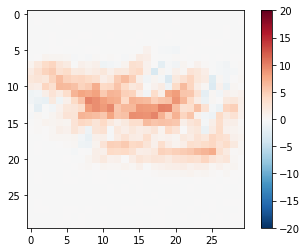

In [41]:
# смотрим тепловую карту (так называемого внимания)
# подаём картинку
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Ошибка дискриминатора**
  * Ошибка дискриминатора принимает 2 входа; **real images, generated images**
  * `real_loss` это `sigmoid cross entropy loss` от **real images** а также **array of ones**
  * `generated_loss` это `sigmoid cross entropy loss` от **generated images** а также **array of zeros**
  * Затем итоговая `total_loss` считается как сумма `real_loss` и `generated_loss`


In [42]:
# бинарная кроссэнтропия (1 - реальное, 0 - фэйк)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [43]:
# функция подсчёта итоговой ошибки
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

Процедура обучения дискриминатора на картинке.

Архитектура и параметры взяты из  [статьи](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Оптимайзеры и Чек-поинты


In [44]:
# использовал параметр бетта как в лекции
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [45]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/Neural Base/AirCheck/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Генерация изображения

Будем использовать несколько функции для изображений.

* Передаём изображения из *тестового* набора в генератор.
* Генератор преобразует изображения.
* Построить сгенерированные изображения и сравнить.

In [46]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # модифицируем изображения для правильной прорисовки
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

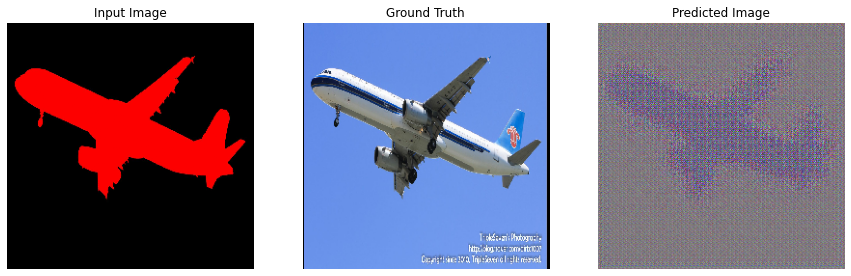

In [47]:
# берем для примера 1 пример из датасета
for example_input, example_target in train_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Обучение

* Для каждого примера генерим выход.
* Дискриминатор получает `input_image` и сгенерированное изображение. Второй вход это `input_image` а также `target_image`.
* Затем считается `generator` и `discriminator loss`.
* Затем мы вычисляем градиенты потерь по отношению к переменным (входам) генератора и дискриминатора и применяем их к оптимизатору.
* Затем записываем лог для TensorBoard.

In [48]:
EPOCHS = 150

In [49]:
# сохраняем в папку с отметкой времени
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [50]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

Как происходит обучение:

* Проходим по количеству заданных эпох.
* Каждую эпоху очищаем экран, и запускаем `generate_images` чтобы показать прогресс.
* В каждую эпоху обучения, печатаем '.' чтобы видеть прогресс.
* Сохраняем чек-поинт каждые 20 эпох.

In [51]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Эпоха: ", epoch)

    # Обучение
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # сохраняем чек-поинт каждые 20 эпох
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Время для эпохи - {} потрачено {} сек\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

Запуск TensorBoard:

In [ ]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

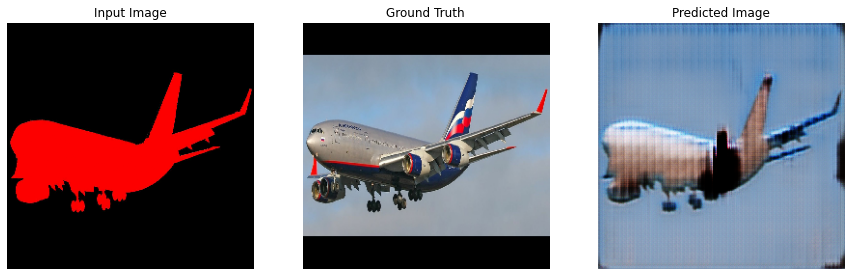

Epoch:  3
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................

KeyboardInterrupt: ignored

In [55]:
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Интерпретация графиков для GAN является более сложной, чем для простой модели нейросети.

На что обращаем внимание:

* **Убедитесь, что ни одна модель не «выигрывает».** Если значение `gen_gan_loss` или` disc_loss` очень низкое, это показатель того, что одна модель доминирует над другой, и вы не успешно обучаете комбинированную модель.
* Значение `log (2) = 0,69` является хорошей контрольной точкой для этих потерь, поскольку оно указывает на то, что дискриминатор в среднем одинаково неопределен в отношении этих двух вариантов.
* Для `disc_loss` значения ниже `0.69` означает что дискриминатор лучше, основываясь на реальные и сгенереррированные картинки.
* Для  `gen_gan_loss` значение около `0.69` означает что генератор лучше чем дискриминатор.
* В процессе обучения `gen_l1_loss` должен уменьшаться.

## Восстановить последний чек-поинт и сгенерировать 5 примеров

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# восстановить последний чек
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

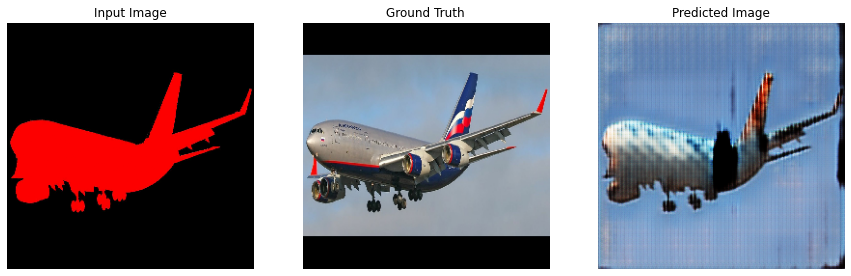

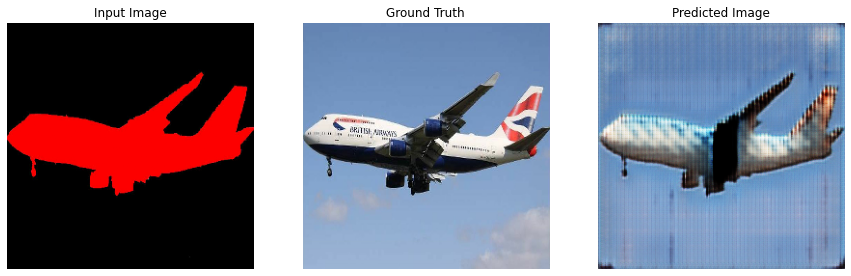

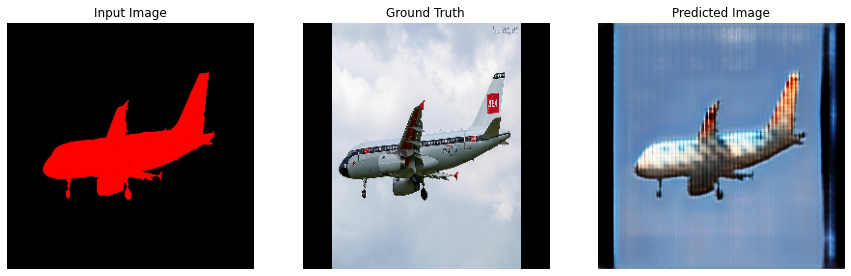

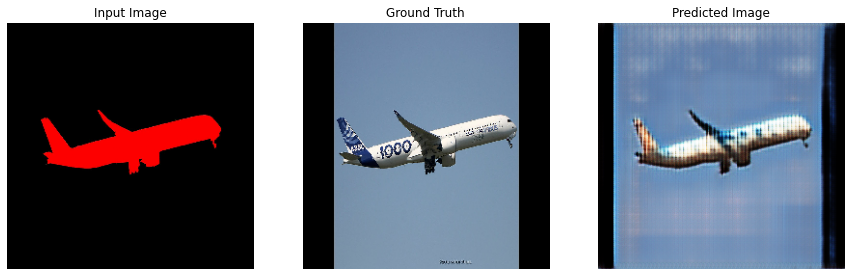

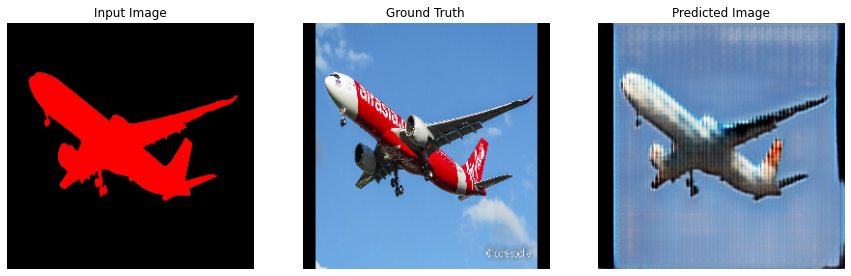

In [57]:
# вывод на экран сгенерированных картинок из тестовой выборки
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)